# Spectral clustering / embedding

Author: Matt Smart

[Overview](#linkOverview)  
[Graph Theory](##linkGraph)   
[Algorithm](#linkAlgorithm)  
[Example: Simple graph cluster walkthrough](#linkExample1)  
[Resources](#linkResources)  

### Overview <a id='linkOverview'></a>
- non-linear dimension reduction technique
- rough idea: Find structure in data from the eigendecomposition of the Laplacian of the data's distance matrix
    - Step 1: Construct graph Laplacian from the pairwise distances between data points
    - Step 2: Find eigendecomposition of the Laplacian
    - Step 3: Use eigendecomposition to find a low dimension embedding of the data or clusters
- can be thought of as the "vanilla version" of related techniques such as diffusion map and umap

### Some minimal graph theory <a id='linkGraph'></a>

#### Graphs
Graphs are denoted by $G=(V,E)$  
- $V$ or $V(G)$ denotes the "vertices" or "nodes"  
- $E$ or $E(G)$ denotes the "edges"  

#### Graph properties
- **_adjacent vertices_**: directly connected by an edge
- **_edge weights_**: edges may or may not have "weights" associated with them, giving a notion of connection strength
- **_connected graph_**: there exists path between any two nodes $i$ and $j$
- **_weighted graph_**: unweighted graphs have all edge weights constant (or $1$), weighted graphs are any deviation from this
- **_undirected graph_**: all edge weights are symmetric
- **_directed graph_**: one or more edge weights are assymmetric
- **_degree of a node_**: $d(j) = \sum_{i} w_{ij} $

#### Matriices that characterize a graph
- $A$ - **_adjacency matrix_**: $a_{ij}=1$ if nodes are adjacent, $0$ otherwise (note $a_{ii}=0$)
- $W$ - **_weight matrix_**: a scaled (i.e. non-boolean) version of the adjacency matrix; typically restrict weights $w_{ij}\geq 0$
- $D$ - **_degree matrix_**: diagonal matrix of degrees of each node; $d_{jj}=\sum_i w_{ij}$
- $L$ - **_graph laplacian_**: $L=D-A$ for unweighted graphs, or $L=D-W$ for weighted graphs

Example from https://towardsdatascience.com/spectral-clustering-for-beginners-d08b7d25b4d8:
<img src="http://cdn-images-1.medium.com/max/1600/1*GD0E2nvpj853wOz5WTB35Q.jpeg" width="700" height="470" />  

$L$ is a useful construction to store and infer graph properties

#### Basic properties of graph laplacian
- off-diagonals are non-positive (if we constrain the weights to be non-negative); diagonals are non-negative
- columns of $L$ sum to zero
- $L$ is positive semi-definite
- the smallest eigenvalue is $\lambda_1=0$, with corresponding eigenvector a "steady state" of the graph (more below)
- algebraic multiplicity of $\lambda_1=0$ corresponds to the number of subgraphs (multiplicity one means $G$ is connected)
- $L$ has $p$ non-negative, real eigenvalues $0=\lambda_1\leq\lambda_2\leq\ldots\leq\lambda_p$

#### Connection to general stochastic processes
- consider using $L$ as generator of dynamics between the nodes of the graph; $v(t)$ describes the state of the graph as real values at each node
- dynamics: $\dot v = -Lv \implies$ trajectories: $v(t)=e^{-Lt}v_0$
- these dynamics preserve $\sum_i v_i$, as well as the sign of the components
- probability flow: $-L_{ij}$ describes the infinitesimal transition rate of probability (or heat, water.. etc) from node $j$ to node $i$
- steady state for connected graph: the unique zero eigenvector $v_0$
- steady state for non-connected graph: any point in the zero-eigenspace with $\lvert v=\sum_a c_a v_{0,a}\rvert=1$

#### Why is it called "Laplacian"?
- recall the heat equation $\frac{\partial u}{\partial t}=\nabla^2 u$
- $L$ is the discrete version of the continuous laplacian operator $\nabla^2$
- suppose space were note continuous but discrete (e.g. mesh of $p$ connected nodes), then $\dot u = -Lu$ would describe heat flow on the mesh

#### For our purposes
- we will assume connected graph and make sure any constructions satisfy this
- nodes of the graph are in 1-1 correspondence with our data points/samples
- edges describe some relationship between data samples (e.g. proximity)

### Algorithm <a id='linkAlgorithm'></a>

#### Setup / input
- suppose one has $p$ samples of N-dimensional data points, $x_i\in\mathbb{R}^N$
- store the data samples columnwise as $X\in\mathbb{R}^{N\,\times\,p}$

#### Step 1: Distance matrix -> Similarity matrix  -> Graph Laplacian

**_Pairwise distances_**: Choose a metric $d(\cdot, \cdot)$.
- often one uses Euclidean distance if data is continuous samples from $\mathbb{R}^N$
- other distances may be more appropriate (e.g. 1-norm if data is binarized)

**_Similarity matrix_**: Crudely, make them inversely proportional to the distances. Goal is to store local relationships between the datapoints.  
Example choices:
- $s_{ij}=\frac{1}{d_{ij}^2}$  
- $s_{ij}(\sigma)=exp(-d_{ij}^2\,/\, 2\sigma^2)$  
- $s_{ij}$ as a boolean indicator function for k-NN
- alternatively, it could correspond to a qualitative ordering / ranking of similarities

Intuition: by associating transition probabilities with similarities, trajectories beginning within "clusters of similar points" will flow throughout said cluster before moving to other clusters. We expect this to be reflected somehow in the eigenspectrum, since for a markov process (e.g. master equation) the eigenspectrum captures info about timescales. 

(This is more physicist/dynamicist interpretation. There is another interpretation based on minimal cuts through graphs discussed in the references, which appears better suited to image detection/clustering scenarios.)

**_Laplacian construction_**: Need to make some choices to build something resembling $L=D-S$.  
First construct diagonal degree matrix $D$ by summing the columns of similarity matrix $S$: $\:\:d_{jj} = \sum_i s_{ij} $.  
Possible Laplacian choices (some are outlined in von Luxburg, 2007): 
1. $L=D-S\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:$ (standard, unnormalized)
2. $L=I-SD^{-1}\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:$  (normalized)
3. $L=I-D^{-1/2}SD^{-1/2}\:\:\:\:\:\:$ (normalized, symmetrized)

#### Step 2: Find eigendecomposition of the Laplacian
- recall spectral structure of Laplacian; obtain $L=V\Lambda V^{-1}$ 
- $\Lambda$ diagonally stores $p$ non-negative, real eigenvalues $0=\lambda_1\leq\lambda_2\leq\ldots\leq\lambda_p$
- $V \in \mathbb{R}^{\,p \times p}$ stores corresponding eigenvectors as columns
- not sure if normalization of eigenvectors is necessary

#### Step 3: (SPECTRAL EMBEDDING) Use eigendecomposition to construct a low-dimension embedding 
- choose some lower dimension $r<N<<p$ (lower than original dimension $N$, which is typically much lower than number of samples $p$)
- consider the truncated eigenvector matrix of the lowest $r$ eigenvectors: $\tilde V \in \mathbb{R}^{p \times r}$
- **_r-dim spectral embedding:_** the latent representations of our original points $x_i \in \mathbb{R}^{N}$ are the $p$ rows of $\tilde V$, denoted by $y_i \in \mathbb{R}^{r}$
- post-processing / normalization may not be not necessary
- various normalization techniques suggest in the literature (e.g. Ng 2002: make the r-dim coordinates unit length)

#### Step 4: (SPECTRAL CLUSTERING) Use low-dimension embedding to choose clusters
- cluster the embedded points using e.g. k-means or more sophisticated techniques
- assign cluster labels back to original points $x_i \in \mathbb{R}^{N}$

#### Notes
- when similarity graph is not fully connected, the multiplicity of the zero eigenvalue gives estimate on the number of clusters
- scikit-learn behaves differently than my direct algorithm... unclear why (see below)

#### Complexity (according to Sckit-learn)
- Spectral Embedding is less than $O\left(p^3\right)$  (where $p$ is the number of $\mathbb{R}^N$ data points)
- Sckit-learn suggests kNN approach typically faster than diffusion kernel approach, seems counterintuitive
- compare vs. PCA $\approx O(p^2)$ and MDS $\approx O(p^3)$

### Example: Walkthrough + basic idea to identify graph clusters <a id='linkExample1'></a>

X data samples shape: (150, 3)
Y data labels shape: (150,)


<IPython.core.display.Javascript object>


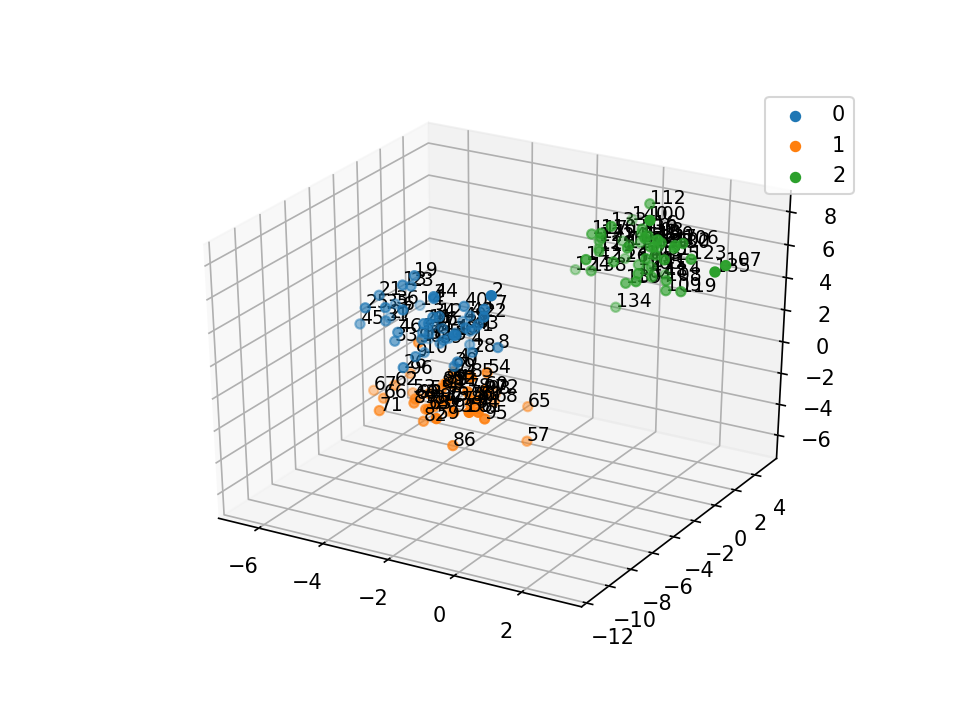

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

p = 150    # num samples
n = 3      # original dimension R^n
k = 3      # number clusters

# generate k blobs in n-dim
X, Y = make_blobs(n_samples=p, centers=k, n_features=n, shuffle=False, random_state=40)
print("X data samples shape:", X.shape)
print("Y data labels shape:", Y.shape)

# visualize data in R^n
fig = plt.figure()
if n == 2:
    for label in set(Y):
        mask = Y==label
        plt.scatter(X[:,0][mask], X[:,1][mask], marker = '.', label = label, s=120, alpha=0.7)
    for i in range(p):
        plt.text(X[i,0],X[i,1], i, fontsize=9)
if n == 3:
    ax = fig.add_subplot(111, projection='3d')
    for label in set(Y):
        mask = Y==label
        ax.scatter(X[:,0][mask], X[:,1][mask], zs=X[:,2][mask], zdir='z', label = label, s=20, c=None, depthshade=True)
    for i in range(p):
        ax.text(X[i,0],X[i,1],X[i,2], i, fontsize=9)
plt.legend()
plt.show()

In [6]:
# compute data distances
distances = pairwise_distances(X, metric='euclidean')

# convert to similarity matrix
sigma = 5
S = np.exp(-distances**2/(2*sigma**2))

# construct degree matrix 
D = np.diag(np.sum(S, axis=0))
assert np.count_nonzero(D - np.diag(np.diagonal(D))) == 0  # confirm D is diagonal before naive inverse
D_inv = np.diag(np.diagonal(D)**(-1))
D_inv_sqrt = np.diag(np.diagonal(D)**(-0.5))
#D_inv = scipy.linalg.inv(D)
#D_inv_sqrt = scipy.linalg.sqrtm(D_inv)
#D_sqrt = scipy.linalg.sqrtm(D)
#D_inv_sqrt = scipy.linalg.inv(D_sqrt)

# construct graph laplacian L = D - S and analogs
L_0 = D - S
L_1 = np.eye(p) - np.dot(S, D_inv)
L_2 = np.eye(p) - np.dot(np.dot(D_inv_sqrt, S), D_inv_sqrt)
laplacians = {0:{'name': 'basic',     'L': L_0}, 
              1:{'name': 'norm',      'L': L_1}, 
              2:{'name': 'sym, norm', 'L': L_2}}

<IPython.core.display.Javascript object>


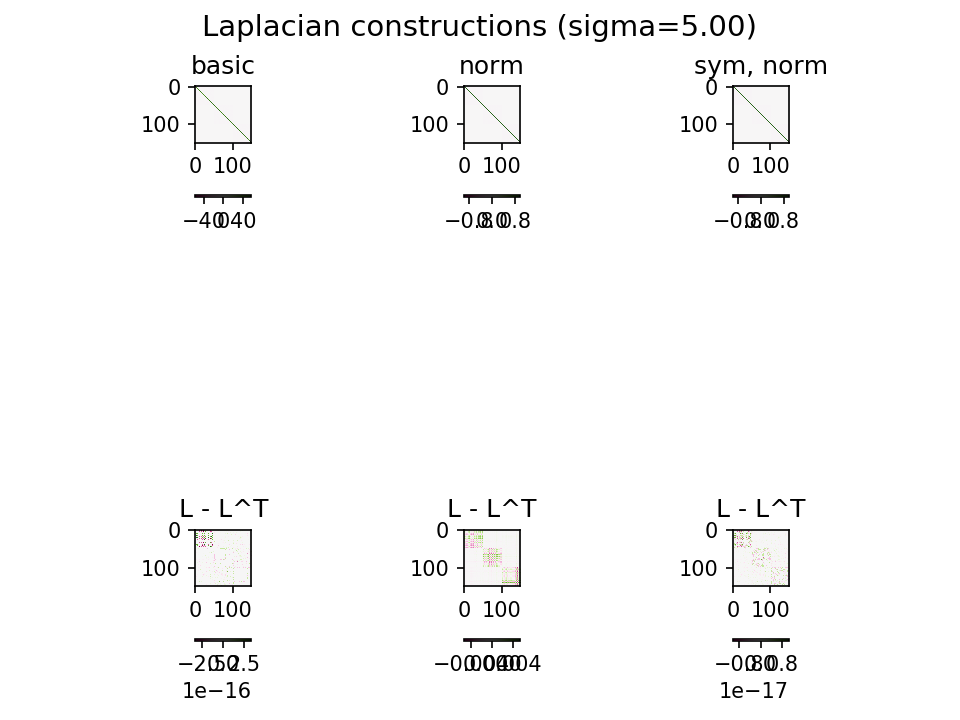

first few column sums... basic
 [-0.000 0.000 -0.000 -0.000 0.000 -0.000 -0.000 0.000 0.000 -0.000]
first few column sums... norm
 [-0.000 -0.000 -0.000 -0.000 0.000 -0.000 -0.000 -0.000 0.000 -0.000]
first few column sums... sym, norm
 [-0.014 -0.005 0.096 0.015 -0.032 -0.025 0.031 -0.033 -0.009 0.027]


In [7]:
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# show laplacians + asymmetry
f, axarr = plt.subplots(2, 3)
f.suptitle("Laplacian constructions (sigma=%.2f)" % sigma, fontsize=14)
for idx in range(3):
    # check column sums -- TODO - issue with L_2 needs to be fixed
    colsum = np.sum(laplacians[idx]['L'], axis=0)
    print("first few column sums... %s\n" % laplacians[idx]['name'], colsum[0:10])
    # plot laplacian L in row 1, and antisymmetric part in row 2
    for row in range(2):
        if row == 0:
            vm = np.max(np.abs(laplacians[idx]['L']))
            im = axarr[row,idx].imshow(laplacians[idx]['L'], cmap='PiYG', vmin=-vm, vmax=vm)
            axarr[row,idx].set_title(laplacians[idx]['name'])
        else:
            R = laplacians[idx]['L'] - laplacians[idx]['L'].T
            vm = np.max(np.abs(R))
            im = axarr[row,idx].imshow(R, cmap='PiYG', vmin=-vm, vmax=vm)
            axarr[row,idx].set_title('L - L^T')
        divider = make_axes_locatable(axarr[row,idx])
        cax = divider.append_axes('bottom', size='4%', pad=0.35)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
f.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


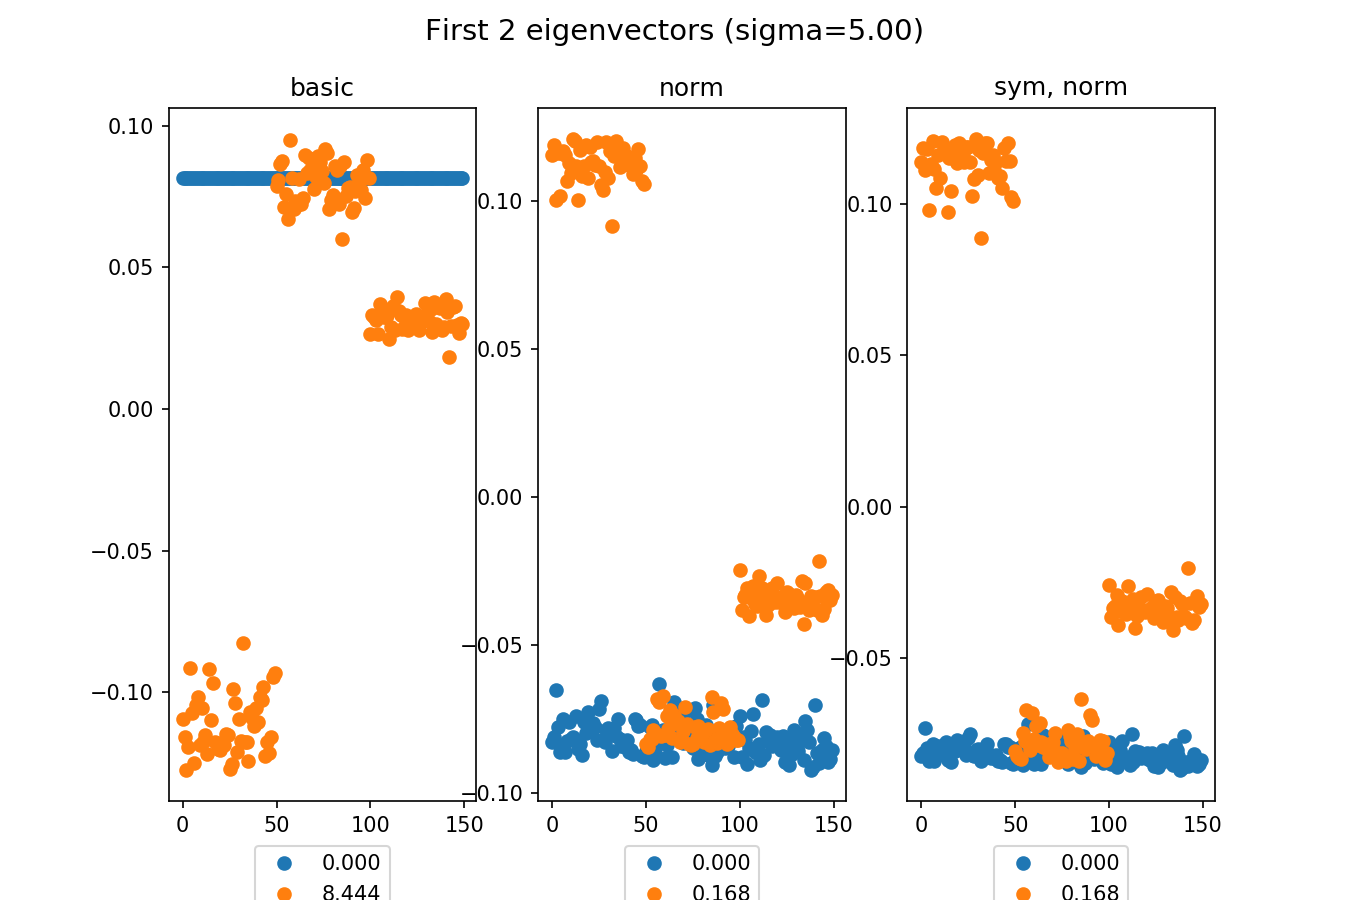

In [8]:
# eigendecomposition of each; sorted
# TODO consider normalization of evec...
for idx in range(3):
    E_unsorted, V_unsorted = np.linalg.eig(laplacians[idx]['L'])
    sortlist = np.argsort(E_unsorted)
    laplacians[idx]['eval'] = E_unsorted[sortlist]
    laplacians[idx]['evec'] = V_unsorted[:,sortlist]

# directly plot the first few eigenvectors for each
num_evec = 2
fig = plt.figure(figsize=(9,6))
fig.suptitle("First %d eigenvectors (sigma=%.2f)" % (num_evec, sigma), fontsize=14)
for idx in range(3):
    ax = fig.add_subplot(1, 3, idx+1)
    for j in range(num_evec):
        ax.plot(laplacians[idx]['evec'][:,j], 'o', label='%.3f' % laplacians[idx]['eval'][j])
    ax.set_title(laplacians[idx]['name'])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
fig.subplots_adjust(hspace=2)
#plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

<IPython.core.display.Javascript object>


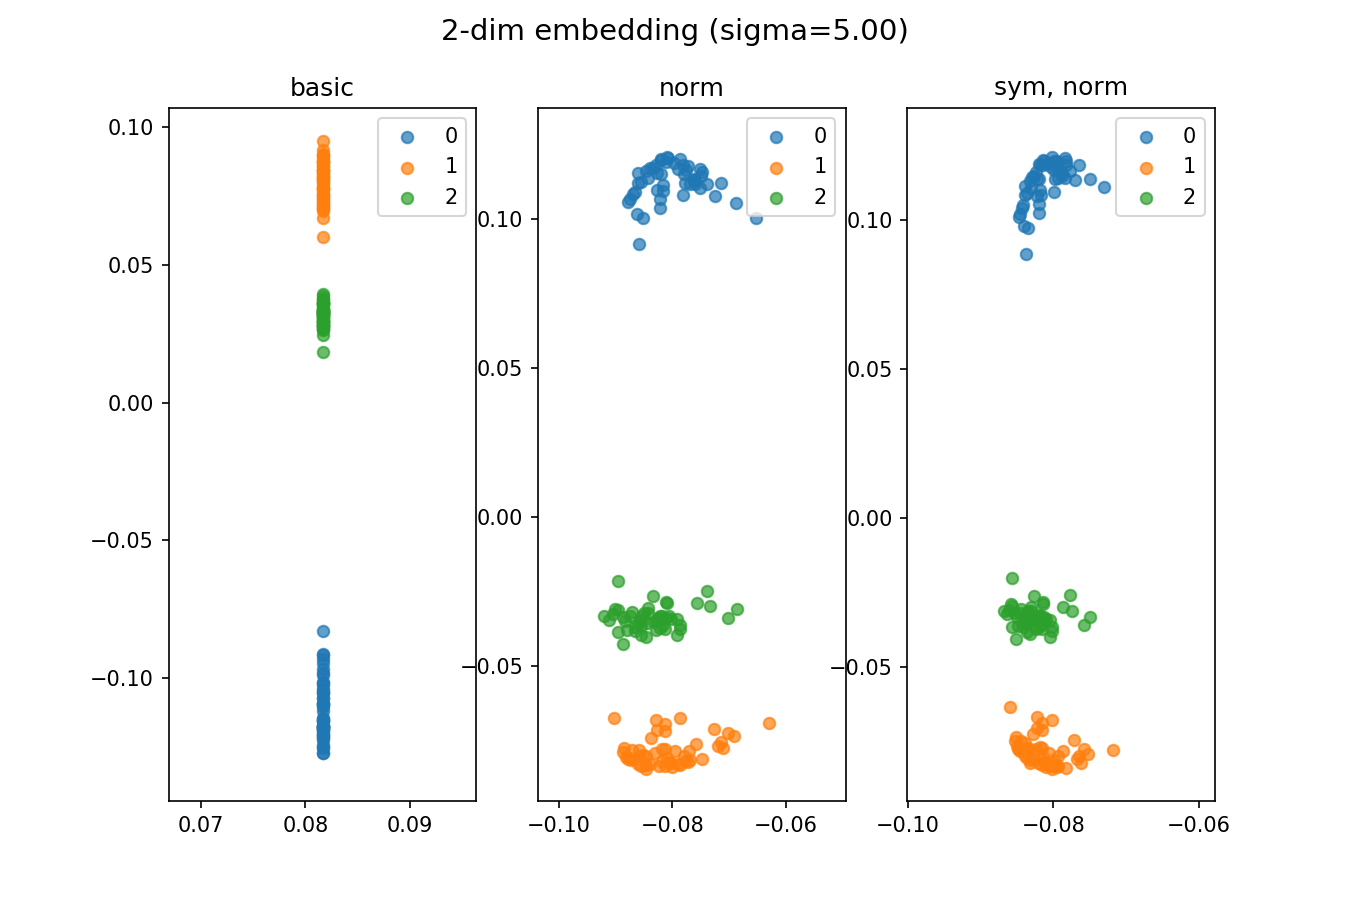

In [9]:
# get r-dim embedding
r = 2
assert r in [2,3]  # so we can plot
for idx in range(3):
    laplacians[idx]['embed_r'] = laplacians[idx]['evec'][:, 0:r]

# normalize all r-dim vectors to length 1 (as in Ng 2002)
for idx in range(3):
    embed_r = laplacians[idx]['embed_r']
    embed_r_norm = np.zeros(laplacians[idx]['embed_r'].shape)
    for j in range(p):
        embed_r_norm[j,:] = embed_r[j,:]/np.linalg.norm(embed_r[j,:])
    laplacians[idx]['embed_r_norm'] = embed_r_norm
    
# plot r-dim embedding with label masks
fig = plt.figure(figsize=(9,6))
plt.suptitle("%d-dim embedding (sigma=%.2f)" % (r, sigma), fontsize=14)
for idx in range(3):
    embed = laplacians[idx]['embed_r']       
    if r==2:
        ax = fig.add_subplot(1, 3, idx+1)
        for label in set(Y):
            mask = Y==label 
            ax.scatter(embed[:,0][mask], embed[:,1][mask], marker = '.', label=label, s=120, alpha=0.7)
    if r==3:
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        for label in set(Y):
            mask = Y==label 
            ax.scatter(embed[:,0][mask], embed[:,1][mask], embed[:,2][mask], label=label)
    ax.set_title(laplacians[idx]['name'])
    ax.legend()
f.subplots_adjust(hspace=3)
plt.show()

<IPython.core.display.Javascript object>


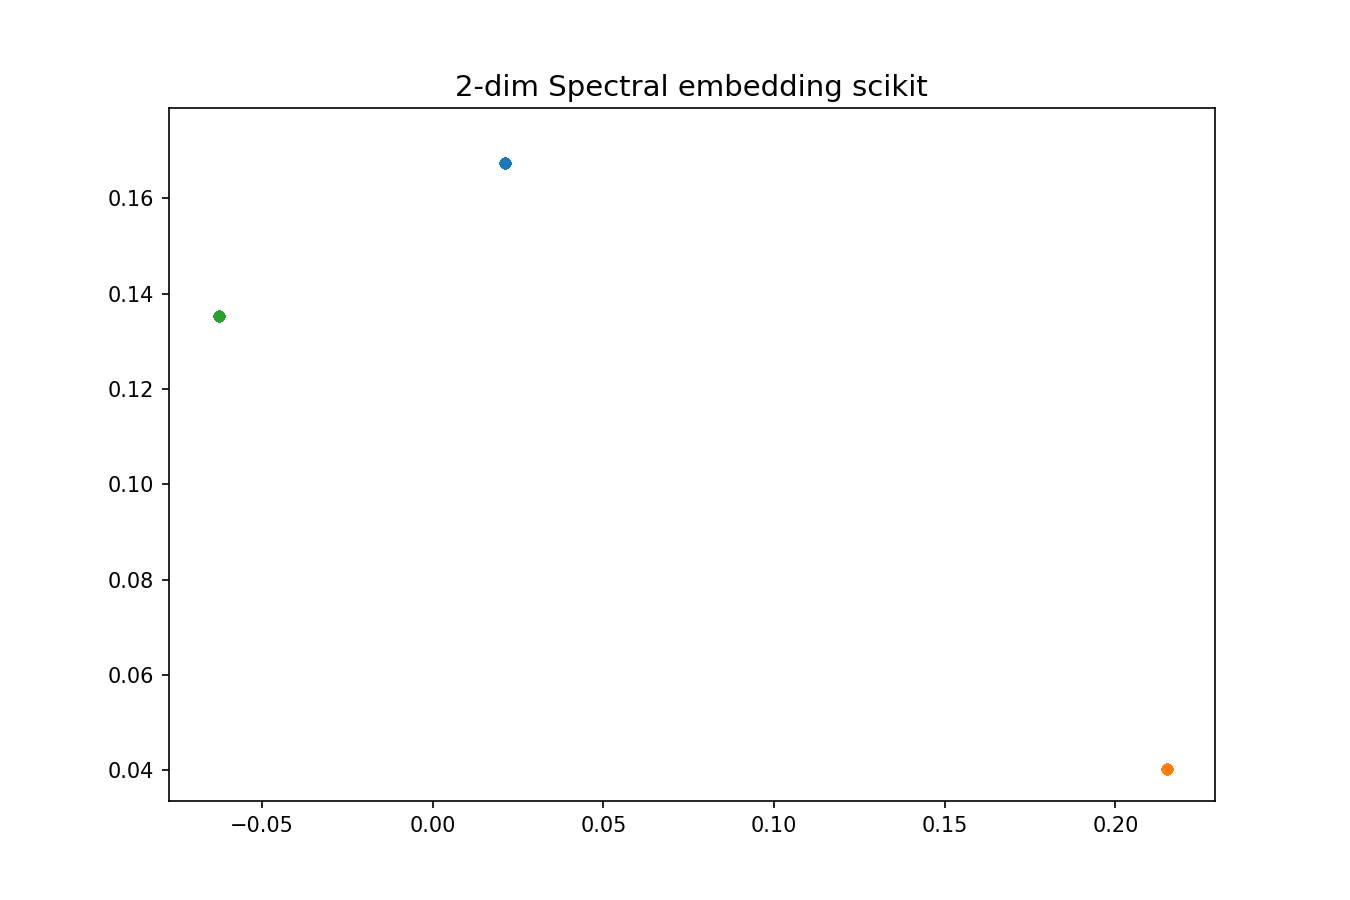

In [10]:
# compare to scikit-learn
from sklearn import cluster, manifold
import time

# compare vs embedding
#spectral_embed = manifold.SpectralEmbedding(n_components=r, eigen_solver='arpack', affinity="nearest_neighbors")
spectral_embed = manifold.SpectralEmbedding(n_components=r, eigen_solver='arpack', affinity="rbf", gamma=sigma)

# BLACK BOX: compute the embedding
t0 = time.time()
X_transformed = spectral_embed.fit_transform(X)
t1 = time.time()

# plot r-dim embedding with label masks
fig = plt.figure(figsize=(9,6))
embed = X_transformed
if r==2:
    for label in set(Y):
        mask = Y==label 
        plt.gca().scatter(embed[:,0][mask], embed[:,1][mask], marker = '.', label=label, s=80, alpha=0.7)
if r==3:
    ax = fig.add_subplot(111, projection='3d')
    for label in set(Y):
        mask = Y==label 
        ax.scatter(embed[:,0][mask], embed[:,1][mask], embed[:,2][mask], label=label, s=80, alpha=0.7)
ax.legend()
plt.title("%d-dim Spectral embedding scikit" % (r), fontsize=14)
plt.show()


In [4]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

spectral_cluster = cluster.SpectralClustering(n_clusters=3, eigen_solver='arpack', affinity="nearest_neighbors")

# predict cluster memberships
t0 = time.time()
spectral_cluster.fit(X)
t1 = time.time()
if hasattr(spectral_cluster, 'labels_'):
    y_pred = spectral_cluster.labels_.astype(np.int)
else:
    y_pred = spectral_cluster.predict(X)

# plot
if n == 2:
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
if n == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], zs=X[:, 2], color=colors[y_pred].tolist(), s=10)
plt.title('Spectral scikit', size=18)


NameError: name 'np' is not defined

### Resources <a id='linkResources'></a>
- On Spectral Clustering - analysis and algorithm (Ng, 2002, NIPS)
- A Tutorial on Spectral Clustering (von Luxburg, 2007)
- REVIEW Community detection in graphs (Fortunato, 2010, arxiv)
- Detecting communities in large networks (Cappoci, 2005, PhysicaA)

#### scikit-learn links
- https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering
- https://scikit-learn.org/stable/modules/manifold.html#spectral-embedding
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding